# **Trabalho Prático I -- Geometria Computacional**

**Nome:** Camila Silva Alves

**Matrícula:** 2019028756

**Nome:** Heitor Henrique dos Santos

**Matrícula:** 2020041957

#**Introdução**
O objetivo desse trabalho é utilizar os algoritmos vistos em sala de aula para determinar apartir de um conjunto de dados se suas classes são linearmente separáveis e se for o caso modelar a reta que separa as duas classes (aqui estamos fazendo uma simplificação em que os dados são pontos no plano e existem apenas dois rótulos, dessa forma o "hiperplano" é a reta que separa as duas classes) a fim de conseguir classificar um novo ponto que seja adicionado futuramente se as classes forem separáveis.

##**Base do trabalho**
Bibliotecas, classes e primitivas que foram importantes para elaborar as principais funções do trabalho.


###Bibliotecas

In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sortedcontainers import SortedList
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

### **Classes**
Aqui foram feitas as três classes que serão usadas durante todo o algoritmo.

A classe `Point` é um simples ponto no plano 2D com coordenadas (x, y) que possui seu próprio método de ordenação que prioriza o eixo x na ordenação, isso será explicado em uma classe futura.

Em seguida temos a classe `Segment` que representa um segmento no plano, assim ela possui um ponto de inicio e um ponto de final do segmento (aqui temos um método para garantir que o ponto inicial tenha a menor coordenada x) como atributos e também uma cor para conseguirmos identificar futuramente a qual poligono o segmento faz parte. É importante ressaltar que o método de ordenação feito para essa classe ordena os segmentos em relação a posição relativa do segmento com respeito a reta vertical que passa pelo ponto de inicio do segmento que está sendo comparado(em caso de empate é considerado maior aquele com maior coeficiente angular), explicaremos melhor o motivo dessa ordenação quando for mostrado o algoritmo de Varredura Linear. Ideia da ordenação:

![Imagem 1](https://cdn.discordapp.com/attachments/965405281754443776/1165333294452310116/Mesmo_inicio.png?ex=65467834&is=65340334&hm=19cb113a4938dcd7e6e2247445acbcd9290d4e3386bd2c9c5abf95bf5cd2128f&)           ![Imagem 2](https://cdn.discordapp.com/attachments/965405281754443776/1165333294703988826/Caso_Geral.png?ex=65467834&is=65340334&hm=6630897c028cce331d7f0a5cd20c9057d24a391a92720234cc165f369b58d628&)


Por último temos a classe `Event` que representará os pontos importantes para a linha de varredura, por isso possui como atributos o ponto em que o evento ocorre, se é um inicio ou fim e também o segmento correspondente ao evento.

In [ ]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __lt__(self, other):
        if self.x == other.x:
            return self.y < other.y
        return self.x < other.x

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y


class Segment:
    def __init__(self, begin, end, color):

        # Garante que todos os pontos de inicio possuam a coordenada x menor
        if (begin.x == end.x):
            end = Point(end.x + 0.01, end.y)

        if (begin.x > end.x):
            self.begin = end
            self.end = begin
        else:
            self.begin = begin
            self.end = end
        self.color = color

    # Dica do Cormen ex 32.2-2 usar produto vetorial para saber a posição relativa
    def __lt__(self, other):
        line_point = Point(self.begin.x, line_equation(
            self.begin.x, other.begin, other.end))
        # Calcular o produto vetorial para determinar a ordem
        cross_product = direction(self.begin, self.end, line_point)

        if cross_product != 0:
            return cross_product > 0

        # Se os segmentos são colineares, considere o coeficiente angular (Caso vértice)
        m = (self.end.y - self.begin.y) / (self.end.x - self.begin.x)
        n = (other.end.y - other.begin.y) / (other.end.x - other.begin.x)
        return m < n

    def __eq__(self, other):
        return (self.begin, self.end, self.color) == (other.begin, other.end, other.color)


class Event:
    def __init__(self, point, event_type, segment):
        self.point = point
        self.event_type = event_type
        self.segment = segment

### **Primitivas**
Implementação das primitivas vistas em sala usando, `segment_intersect` calcula se dois segmentos se intersectam utilizando as primitivas `direction` que retorna o resultado do produto vetorial e `on_segment` que checa se o ponto está no segmento para o caso em que o produto vetorial retorna zero, isto é, se os segmentos forem colineares.

In [ ]:
# Calcula a orientação usando produto vetorial
def direction(p0, p1, p2):
    return ((p1.x - p0.x) * (p2.y - p0.y)) - ((p2.x - p0.x) * (p1.y - p0.y))

# Caso os segmentos seja colineares checamos se o ponto está no intervalo do segmento
def on_segment(p0, p1, p2):
    if ((p0.x <= p2.x <= p1.x) or (p1.x <= p2.x <= p0.x)) and ((p0.y <= p2.y <= p1.y) or (p1.y <= p2.y <= p0.y)):
        return True
    return False

# Equação da reta a fim de achar as coordenadas y em respeito a linha vertical da varredura
def line_equation(x, point1, point2):
    x1, y1 = point1.x, point1.y
    x2, y2 = point2.x, point2.y

    m = (y2-y1)/(x2-x1)
    return m*(x - x1) + y1

# Algoritmo de interseção usando as primitivas (Cormen)
def segment_intersect(seg1, seg2):
    p1 = seg1.begin
    p2 = seg1.end
    p3 = seg2.begin
    p4 = seg2.end

    d1 = direction(p3, p4, p1)
    d2 = direction(p3, p4, p2)
    d3 = direction(p1, p2, p3)
    d4 = direction(p1, p2, p4)

    if ((d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0)) and ((d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0)):
        return True
    elif d1 == 0 and on_segment(p3, p4, p1):
        return True
    elif d2 == 0 and on_segment(p3, p4, p2):
        return True
    elif d3 == 0 and on_segment(p1, p2, p3):
        return True
    elif d4 == 0 and on_segment(p1, p2, p4):
        return True
    else:
        return False

##**Algoritmos Principais**

### **Convex Hull**

Neste trabalho foi implementado o algoritmo de Jarvis (Gift Wrapping) para encontrar a envoltória convexa de um dado conjunto $C$ de pontos em $\mathbb{R}^2$. A complexidade desse algoritmo é $O(n \log n)$

A ideia deste algorítmo é simples. Começamos a iteração do ponto mais a esquerda e incluimos na envoltura o próximo ponto em "posição mais anti-horária". Um ponto $i$ assume uma posição "mais antihorária" do que $q$,em relação a um ponto $p$, quando o caminho $p ⟶ i ⟶ q$ é anti-horário.

Dessa forma, iteramos os pontosdo Conjunto $C$ a procura do próximo ponto "mais antihorário" até chegar no ponto inicial.

Para encontrar o próximo ponto na envoltura, isto é, o mais antihorário, foi implementado o método `orientation(self, p1, p2, p3)` que retorna 1, caso a orientação do caminho $p1 ⟶ p2 ⟶ p3$ for horária; 2, caso antihorária; ou 0, caso os pontos sejam colineares.

O método `ConvexHull.gift_wrapping(self)` implementa o algoritmo de Jarvis e retorna uma lista ordenada de pontos que compõem a envoltória do conjunto C.


In [ ]:
class ConvexHull:
    def __init__(self):
        self.points = []

    def gift_wrapping(self):
        hull = []

        n = len(self.points)

        if n < 3:
            return hull

        # Encontra o ponto mais à esquerda
        first = 0
        p, q = 0, 0

        for i in range(n):
            if self.points[i].x < self.points[first].x:
                first = i

        # Faça a envoltura em sentido anti-horário, enquanto não voltamos para o ponto inicial
        p = first

        while True:
            hull.append(self.points[p])

            # q é o próximo ponto no vetor points, depois de p
            q = (p + 1) % n

            for i in range(n):
                # Se o caminho p-> i -> q for no sentido anti-horário, então i envelopa q
                if self.orientation(self.points[p], self.points[i], self.points[q]) == 2:
                    q = i

            p = q

            if p == first:
                break

        return hull

    def orientation(self, p1, p2, p3):
        a = (p2.y - p1.y) * (p3.x - p2.x) - (p3.y - p2.y) * (p2.x - p1.x)

        if a == 0:
            return 0
        elif a > 0:
            return 1
        else:
            return 2

###**Varredura Linear**
Antes de implementar o algoritmo é necessário criar alguns métodos auxiliares, sendo eles `above` e `below` que dado um segmento em uma SortedList iteram por essa estrutura até encontrar o segmento que está acima ou abaixo do segmento de entrada. SortedList um container da biblioteca ***sortedcontainers*** que combina características de uma lista com uma árvore binária de busca balanceada, dessa forma é possível adicionar e remover elementos de forma eficiente $O(logn)$ ao passo que a ordem se mantém.

Além disso criamos nossa própria função para remover elementos da Sortedlist já que tivemos alguns problemas com os iteradores da biblioteca que não encontravam elementos que estavam na lista, por conta desses problemas checar se elemento está acima, abaixo, ou remover um elemento é $O(n)$ sendo n a quantidade de elementos na lista.

In [ ]:
def above(T, p):
    iterator = iter(T)
    for seg in iterator:
        if seg == p:
            try:
                return next(iterator)
            except StopIteration:
                return None  # Se for a última iteração
    return None  # Se não encontrarmos o elemento na lista

def below(T, p):
    iterator = iter(T)
    prev_seg = next(iterator, None)  # Obter o primeiro elemento da lista
    for seg in iterator:
        if seg == p:
            return prev_seg  # Se encontrarmos o elemento p, retorne o elemento anterior
        prev_seg = seg
    return None  # Se não encontrarmos o elemento na lista

def remove_element(T, p):
    T_segments = list(T)
    for seg in T_segments:
        if seg == p:
            T_segments.remove(seg)  # Remove o elemento p do conjunto T
            #Sorted list recebe a lista com o elemento removido
            T = SortedList(T_segments)
    return T

#### SweepLine ####

A função `sweep_line` recebe uma lista de segmentos e retorna verdadeiro caso exista intersecção entre segmentos de cores distintas e falso em qualquer outro caso.

Inicialmente criamos uma lista de endpoints que será responsável por guardar os eventos na ordem em que eles devem acontecer segundo a linha de varredura. Para isso ordenamos os eventos em ordem crescente em relação a coordenada x, em caso de empate são colocados os eventos do tipo final primeiro. Em seguida iteramos por todos os eventos seguindo a lógica do algoritmo visto em sala com a modificação de que apenas retornamos true caso a interseção encontrada seja entre segmentos de cores distintas (isso porque o algoritmo será usado para detectar se dois poligonos convexos se intersectam, o algoritmo padrão retornaria true sempre devido a interseção dos segmentos no vértice do poligono). Portanto, se o evento é do tipo begin adicionamos o segmento correspondente em uma SortedList, e em seguida comparamos se existe interseção de cores distintas entre o segmento diretamente acima ou diretamente abaixo.

Aqui explicaremos melhor a ordenação que escolhemos para a classe `Segment` que será usada pela Sortedlist que guarda os segmentos ativos. Sempre que um novo segmento é adicionado na lista de segmentos ativos precisamos saber a ordem dele em relação a linha de varredura. Para isso usamos a dica de comparação do atividade 32.2-2 do livro **Introduction to Algorithms** do Cormen. Assim usamos o produto vetorial entre o segmento que está sendo adicionado com o segmento que começa no inicio desse segmento e termina no ponto de interseção entre o segmento comparado e a reta de varredura (na imagem anterior o segmento que está sendo adicionado seria o A e o comparado o B), dessa forma, quando os segmentos não se intersectam é possível saber se o segmento adicionado está abaixo ou acima do comparado. Se existir interseção de mesma cor, isto é, um vértice do meu poligono, usando o coeficiente angular, se a inclinação de uma reta A é maior que a de uma B então A deve ficar acima de B.

Voltando ao algoritmo, quando o evento analisado é do tipo end, então verificamos se o seguimento diretamente acima dele se intercecta com o segmento diretamente abaixo dele, se há intersecção retornamos true se não removemos o segmento relacionado ao end da nossa lista e prosseguimos para a próxima iteração, repetindo o processo até o último evento, se depois de todos eles não tivemos interseção então ela não existe e retornamos falso para a existência de interseção nesse conjunto de segmentos.

In [ ]:
def sweep_line(segments):
    end_points = []
    T = SortedList()

    for seg in segments:
        begin_event = Event(min(seg.begin, seg.end), 'begin', seg)
        end_event = Event(max(seg.begin, seg.end), 'end', seg)
        end_points.append(begin_event)
        end_points.append(end_event)

    # Ordena os eventos com base no atributo x, inicio/fim, y
    end_points.sort(key=lambda x: (x.point.x, x.event_type == 'begin'))

    for p in end_points:
      # Checamos se o segmento adicionado se intersecta com o de cima ou de baixo
        if (p.event_type == 'begin'):
            T.add(p.segment)
            above_p = above(T, p.segment)
            below_p = below(T, p.segment)

            if ((above_p and above_p.color != p.segment.color and segment_intersect(above_p, p.segment)) or
               (below_p and below_p.color != p.segment.color and segment_intersect(below_p, p.segment))):
                return True
      #Checamos se o de cima e o de baixo do segmento que será removido se intersectam
        if (p.event_type == 'end'):
            above_p = above(T, p.segment)
            below_p = below(T, p.segment)

            if ((above_p and below_p and above_p.color != below_p.color) and
               (segment_intersect(above_p, below_p))):
                return True

            T = remove_element(T, p.segment)

    return False

##**Verificar se duas envoltórias são linearmente separáveis**
Para fazer isso é necessário contruir primeiramente uma função que dado o conjunto de pontos da envoltória retorne um conjunto de segmentos com uma cor escolhida, no nosso caso a cor representará a classe a qual a envoltória representa.

In [ ]:
def points_to_segment_list(points, color):
  segments = []
  n = len(points)
  for i in range(n-1):
    segments.append(Segment(points[i], points[i + 1], color))
  segments.append(Segment(points[-1], points[0], color))
  return segments

Essa função, unida aos algoritmos que encontram a envoltória convexa e que detectam interseções de segmentos, é capaz de construir uma nova função que retorne se duas envoltórias são linearmente separáveis, ou seja, se o poligono de uma envoltória não se intersecta com o poligono de outra envoltória

In [ ]:
def linearly_separable(blue_polygon, red_polygon):
  convex_blue = ConvexHull()
  convex_red = ConvexHull()
  convex_blue.points = blue_polygon
  convex_red.points = red_polygon

  blue_points = convex_blue.gift_wrapping()
  red_points = convex_red.gift_wrapping()

  blue_segments = points_to_segment_list(blue_points, 0)
  red_segments = points_to_segment_list(red_points, 1)

  all_segments = blue_segments + red_segments

  return not(sweep_line(all_segments)), all_segments


###**Construção do Modelo Linear no caso em que as classes são separáveis**

No caso em que as envoltórias são linearmente separáveis precisamos de um algoritmo que mostre na tela os resultados. Para isso é necessário algumas funções adicionais para obter a menor reta entre as duas envoltórias e também a reta ortogonal a esta a fim de mostrar a separabilidade e a forma em que será feita a classificação de pontos adicionados após o treinamento com as novas amostras.

###Distância entre poligonos

Para encontrar a menor distânicia entre dois polignos diferentes, comparamos a distância entre os vértices dos polignos e escolhemos a menor. Isso é feito em $O(n^2)$.

 É claro que a menor distância entre dois polignos não é necessariamente a menor distância entre os vértices. Isso ocorre, pois pode haver pontos dentro das arestas dos polignos que mapeam uma distância mínima entre os polignos.
Contudo, para fins didáticos, a solução que implementamos foi suficiente.

In [ ]:
def distanceSquared(p1, p2):
  return (p2.x - p1.x)**2 + (p2.y - p1.y)**2

def polygonsDistance(q, r):
  d = math.inf
  pointQ = q[0]
  pointR = r[0]

  for p1 in q:
    for p2 in r:
      x = distanceSquared(p1, p2)
      if x < d:
        d = x
        pointQ = p1
        pointR = p2
  return pointQ, pointR

###Reta Perpendicular

Sejam $p_1 = (x_1, y_1), p_2 = (x_2, y_2) \in \mathbb{R}^2 $
A reta perpendicular $l =  a'x + b'$ que passa no ponto médio do seguimento de reta $p_1p_2$ pode ser encontrada da seguinte maneira.

Sabemos que a inclinação $a'$ de $l$ relaciona-se com a inclinação $a$ do segmento $p_1p_2$ de modo que:

$a \cdot a' = 1 ⇒ a' = a^{-1}$

e

$a = \dfrac{y_1 - y_2}{x_1 - x_2}$


O valor de $b'$ pode ser calculado a partir do ponto médio $p_m = (\frac{x_2 + x_1}{2}, \frac{y_2 + y_1}{2} )$ de $p_1p_2$, de modo que

$b' = \dfrac{y_2 + y_1}{2} - a' \cdot \dfrac{x_2 + x_1}{2} $

Assim a reta perpendicular é calculada na função `perpendicularLine(p1, p2)`  em tempo $O(1)$. Essa função retorna o valor de $a'$ e $b'$.




In [ ]:
from mpl_toolkits.mplot3d.axes3d import proj3d
def perpendicularLine(p1, p2):
  a1 = (p2.y - p1.y) / (p2.x - p1.x)

  if (a1 != 0):
    a2 = -(1.0/a1)
  else:
    a2 = math.inf


  ym = (p1.y + p2.y)/2
  xm = (p1.x + p2.x)/2

  b = ym - a2*xm
  print("Reta perpendicular: ", a2, "x + ", b)
  return a2, b

###Classificador de Amostras
Dado um uma nova amostra precisamos saber a qual rótulo ela deve se encaixar. Para isso usaremos a reta y(x) = ax + b perpendicular ao segmento que define a distância entre os poligonos. Assim, dado um ponto, a ser classificado, $p_i = (x_i,y_i)$, se $y_i < y(x_i)$, $y_i \in$ a classe 0; caso se $y_i > y(x_i)$, $y_i \in$ a classe 1.

In [ ]:
def amostra_real(classe0, classe1):
    amostra = []
    for i in classe0:
        amostra.append(0)
    for i in classe1:
        amostra.append(1)
    return amostra

# Posição do ponto em relação a reta ortogonal ao ponto médio
def relative_position(a, b, point, x_med):
    if a == math.inf:  # Se a reta é vertical
        if point.x < x_med:
            return "left"
        elif point.x > x_med:
            return "right"
        else:
            return "in_line"
    elif a == 0:  # Se a reta é horizontal
        if point.y < b:
            return "below"
        elif point.y > b:
            return "above"
        else:
            return "in_line"
    else:  # Se a reta é inclinada
        y_na_reta = a * point.x + b
        if point.y > y_na_reta:
            return "above"
        elif point.y < y_na_reta:
            return "below"
        else:
            return "in_line"

def classify_points(test_points, a, b, point, x_med, flag_class):
    amostra =[]
    true_class = relative_position(a, b, point, x_med)
    if(flag_class == 0):
        for i in test_points:
            test_class = relative_position(a, b, i, x_med)
            if test_class == true_class:
                amostra.append(0)
            elif test_class == "in_line":
                amostra.append(-1)
            else:
                amostra.append(1)
        return amostra
    elif(flag_class == 1):
        for i in test_points:
            test_class = relative_position(a, b, i, x_med)
            if test_class == true_class:
                amostra.append(1)
            elif test_class == "in_line":
                amostra.append(-1)
            else:
                amostra.append(0)
        return amostra

In [ ]:
def plot_segments(segments, a = None, b =None):
    fig, ax = plt.subplots()
    lines = [[(seg.begin.x, seg.begin.y), (seg.end.x, seg.end.y)]
             for seg in segments]
    lc = LineCollection(lines, colors=['red' if seg.color == 0 else 'blue' if seg.color == 1 else 'green' for seg in segments], linewidths=2)
    ax.add_collection(lc)

    if a is not None and b is not None:
        # Encontrando os limites horizontais do gráfico
        x_min = min(seg.begin.x for seg in segments)
        x_max = max(seg.end.x for seg in segments)

        # Calculando os pontos correspondentes da linha reta
        x_vals = [x_min, x_max]
        y_vals = [a * x + b for x in x_vals]
        plt.plot(x_vals, y_vals, color='black', linewidth=2, label='Custom Line')

    plt.autoscale()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

###Computação das Métricas e métodos que serão usados nos testes

In [ ]:
def metrics(train_class0, train_class1, test_class0, test_class1):

  #Calcula as envoltórias dos pontos de treino
  convex_hull = ConvexHull()
  convex_hull.points = train_class0
  polygon_class0 = convex_hull.gift_wrapping()
  convex_hull.points = train_class1
  polygon_class1 = convex_hull.gift_wrapping()

  separable, all_segments = linearly_separable(polygon_class0, polygon_class1)

  #Caso as classes forem separáveis linearmente plotamos as métricas dos testes
  if(separable):
    p1, p2 = polygonsDistance(polygon_class0, polygon_class1)
    x_med = (p1.x + p2.x)/2 # Recupera o ponto médio para tratarmos o caso em que a reta é vertical

    #Menor distancia entre os vértices
    distance = Segment(p1, p2, 2)
    a, b = perpendicularLine(p1,p2) #Recebe o a e b da equação da reta y = a*x+b

    #Adiciona o segmento da menor distância para quando plotarmos o gráfico
    all_segments.append(distance)
    plot_segments(all_segments, a, b)

    amostra_classe0_classificada = classify_points(test_class0, a, b, p1, x_med, 0)
    amostra_classe1_classificada = classify_points(test_class1, a, b, p2, x_med, 1)

    testes_classificados = amostra_classe0_classificada + amostra_classe1_classificada
    resultado_real = amostra_real(test_class0, test_class1)


    precision = precision_score(testes_classificados, resultado_real)
    recall = recall_score(testes_classificados, resultado_real)
    f1 = f1_score(testes_classificados, resultado_real)

    print(f"precision: {precision}")
    print(f"recall: {recall}")
    print(f"f1-score: {f1}")
  else:#Caso contrário plotamos os poligonos e que eles não são separáveis
    plot_segments(all_segments)
    print("Não é linearmente separável")

###Teste do Modelo

Ao utilizar modelos de classificação, precisamos de algumas métricas para avaliar a qualidade do modelo. Neste trabalho as métricas observadas foram precisão, revocação e f1-score.

Para entender essãs métricas, é importante conhecer a matriz de confusão. Uma matriz de confusão é uma tabela que mostra os erros e acertos do seu modelo, comparados com o resultado esperado. Dessa forma, conseguimos mapear os casos que foram classificados corretamente ou não no modelo. A figura abaixo exemplifica essa matriz para um caso binário:




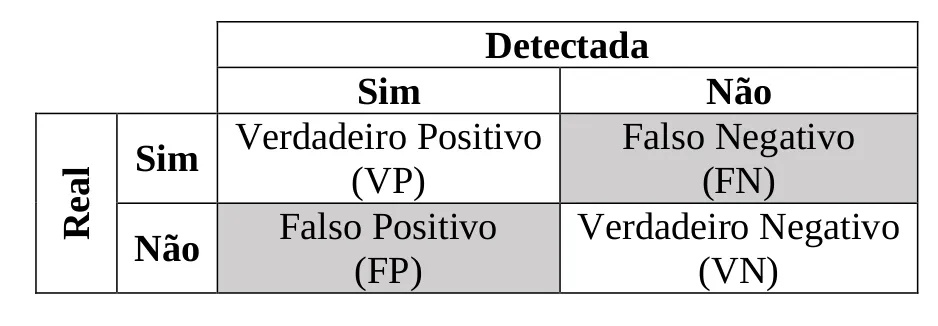

As métricas de um modelo se baseam nos valores da matriz de confusão para ele. Veja como as usadas neste trabalho são calculadas e o que representam.

####Precisão
 É o número de exemplos que seu modelo previu para uma classe e acertou dividido pelo número total de exemplos que ele previu para esta classe.Dessa forma, a precisão mede o quanto podemos confiar num modelo quando ele prevê que um exemplo pertence a uma determinada classe.

####Revocação (Recall)
A revocação é o número de pessoas que o modelo identificou corretamente como uma classe dividido pelo número total de pessoas que realmente está na classe nos dados. Ou seja, de todas as pessoas que o modelo poderia classificar numaa classe, quantas ele acertou.

####F1-score
O f1-score é a média harmônica entre a precisão e a revocação.

In [ ]:
def test_data(dado, dimensao1, dimensao2, classe0, classe1):
    # Filtrar os dados para selecionar apenas duas classes (por exemplo, classes 0 e 1)
    indices_classe0 = dado.target == classe0
    indices_classe1 = dado.target == classe1

    x_classe0 = dado.data[indices_classe0][:, [dimensao1, dimensao2]]
    y_classe0 = dado.target[indices_classe0]
    x_classe1 = dado.data[indices_classe1][:, [dimensao1, dimensao2]]
    y_classe1 = dado.target[indices_classe1]

    # Dividir os dados em conjuntos de treinamento e teste (70% para treino, 30% para teste)
    x_classe0_train, x_classe0_test, y_classe0_train, y_classe0_test = train_test_split(x_classe0, y_classe0, test_size=0.3, random_state=42)
    x_classe1_train, x_classe1_test, y_classe1_train, y_classe1_test = train_test_split(x_classe1, y_classe1, test_size=0.3, random_state=42)

    # Chame a função metrics para calcular as métricas para as duas classes
    pontos_treino_classe0 = [Point(features[0], features[1]) for features in x_classe0_train]
    pontos_treino_classe1 = [Point(features[0], features[1]) for features in x_classe1_train]
    pontos_teste_classe0 = [Point(features[0], features[1]) for features in x_classe0_test]
    pontos_teste_classe1 = [Point(features[0], features[1]) for features in x_classe1_test]

    metrics(pontos_treino_classe0, pontos_treino_classe1, pontos_teste_classe0, pontos_teste_classe1)

##Teste 1
###Iris Plants Dataset

Primeiro teste usando o dataset iris da biblioteca scikit-learn.


Esse dataset contém 3 classes, 150 Instancias (50 em cada classe) e quatro atributos numéricos.

Foram usados dois dos atributos, tamanho e largura da sépala, e duas das classes, Iris-Setosa e Iris-Versicolour, com 70% dos dados para treino e 30% para a execução do teste.

A envoltória vermelha é referente aos dados de treino da classe Iris-setosa e a azul refere-se a classe Iris-Versicolour na imagem abaixo. Como nota-se visualmente, as classes são separáveis. Logo, conseguimos classificar os dados de testes.

O modelo que classifica o treino é a reta $ y(x) = -4x + 21.15$. Os dados de testes foram classificados conforme o classificador implementado. De modo que, a classe 0 é vermelha e a classe 1 é azul.

As métricas obtidas foram

* precisão: 1.0
* revocação: 0.5357142857142857
* f1-score: 0.6976744186046512

Reta perpendicular:  -4.0 x +  21.15


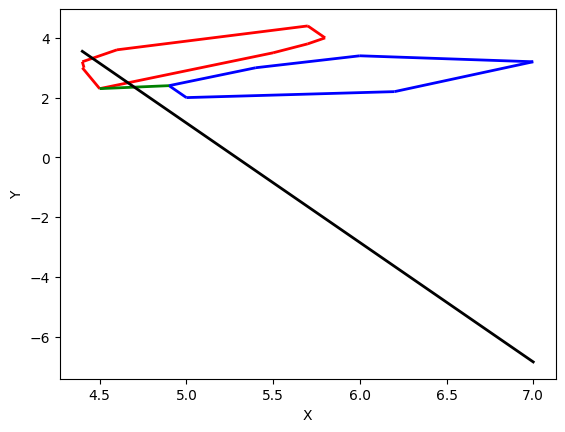

precision: 1.0
recall: 0.5357142857142857
f1-score: 0.6976744186046512


In [ ]:
from sklearn.datasets import load_iris
iris = load_iris()
test_data(iris, 0, 1, 0, 1)

##Teste 2
### Wine Recognition dataset
Teste com o dataset wine Recognition da biblioteca scikit-learn.

Esse dataset contém 3 classes, 178 Instancias e 13 atributos numéricos.

Foram usados dois dos atributos, álcool e tom do vinho, e duas das classes, class_0 e class_1, com 70% dos dados para treino e 30% para a execução do teste.

A envoltória vermelha é referente aos dados de treino da classe class_0 e a azul refere-se a classe class_1 na imagem abaixo. Como nota-se visualmente, as classes são separáveis. Logo, conseguimos classificar os dados de testes.

O modelo que classifica o treino é a reta $ y(x) =  -0.60 x +  10.20$. Os dados de testes foram classificados conforme o classificador implementado. De modo que, a classe 0 é vermelha e a classe 1 é azul.

As métricas obtidas foram:
* precisão: 1.0
* revocação: 1.0
* f1-score: 1.0

1.6666666666666505   -0.6000000000000059
12.99   2.41
Reta perpendicular:  -0.6000000000000059 x +  10.204000000000075


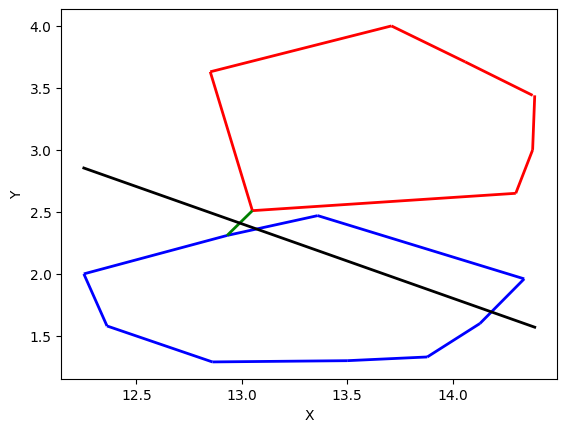

precision: 1.0
recall: 1.0
f1-score: 1.0


In [ ]:
from sklearn.datasets import load_wine
wine = load_wine()
test_data(wine, 0, 11, 0, 2)

##Teste 3
### Breast cancer wisconsin (diagnostic) dataset
Teste com o dataset Breast cancer wisconsin da biblioteca scikit-learn.

Esse dataset contém 2 classes, 569 Instancias e 30 atributos numéricos.

Foram usados dois dos atributos, raio e textura da mama, e as duas classes WDBC-Malignant e WDBC-Benign, com 70% dos dados para treino e 30% para a execução do teste.

A envoltória vermelha é referente aos dados de treino da classe WDBC-Malignant  e a azul refere-se a classe WDBC-Benign na imagem abaixo. Como nota-se visualmente, as classes não são linearmente separáveis. Assim, o modelo não pode ser calculado e não conseguimos classificar os pontos de teste.

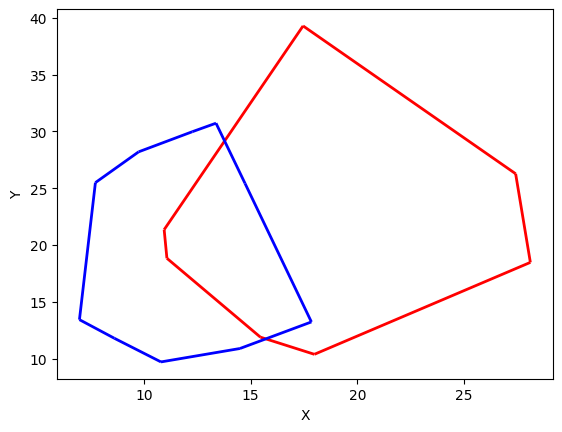

Não é linearmente separável


In [ ]:
from sklearn.datasets import load_breast_cancer
breast = load_breast_cancer()
test_data(breast, 0, 1, 0, 1)

##Teste 4

### fetch olivetti faces dataset
Teste com o dataset fetch_olivetti_faces da biblioteca scikit-learn.

Esse dataset contém 40 classes e  400  Instancias.

Foram usados dois dos atributos, 0 e 1, e duas das classes, class_0 e class_1, com 70% dos dados para treino e 30% para a execução do teste.

A envoltória vermelha é referente aos dados de treino da classe class_0 e a azul refere-se a classe class_1 na imagem abaixo. Como nota-se visualmente, as classes são separáveis. Logo, conseguimos classificar os dados de testes.

O modelo que classifica o treino é a reta $ y(x) =  -0.750 x +  0.996$. Os dados de testes foram classificados conforme o classificador implementado. De modo que, a classe 0 é vermelha e a classe 1 é azul.

As métricas obtidas foram:

* precisão: 0.6666666666666666
* revocação: 1.0
* f1-score: 0.8

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
1.3333334   -0.7499999776482589
0.5681818127632141   0.5702479481697083
Reta perpendicular:  -0.7499999776482589 x +  0.9963842950422661


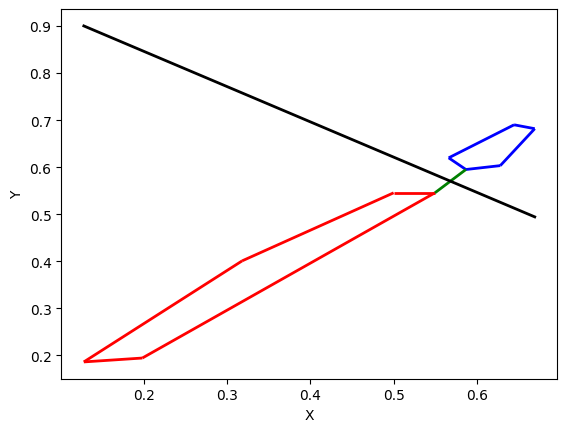

precision: 0.6666666666666666
recall: 1.0
f1-score: 0.8


In [ ]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces(shuffle=True, random_state=42)
test_data(faces, 0, 1, 0, 1)

In [ ]:
def treinosETestes(dfname: str, classification:str, cond1, cond2 ,columnName1:str , columnName2:str ):
  df = pd.read_csv(dfname)

  a = []
  b = []

  for index, row in df.iterrows():
    p = Point(row[columnName1], row[columnName2])
    if row[classification] == cond1:
      a.append(p)
    elif row[classification] == cond2:
      b.append(p)

  na = len(a)
  nb = len(b)

  sizeTreinoA = int(0.7 * na)
  sizeTreinoB = int(0.7 * nb)

  treinoA = [a[i] for i in range(sizeTreinoA)]
  testeA = [a[i] for i in range(sizeTreinoA, na)]
  treinoB = [b[i] for i in range(sizeTreinoB)]
  testeB = [b[i] for i in range(sizeTreinoB, nb)]

  return treinoA, testeA, treinoB, testeB


In [ ]:
def test_data2(dfname, classification, cond1, cond2, columnName1, columnName2):
  ta, tta, tb, ttb = treinosETestes(dfname, classification, cond1, cond2, columnName1 , columnName2)
  metrics(ta, tb, tta, ttb)

##Teste 5

### Banana dataset
Teste com o dataset banana do repositório  [standard_classification](https://github.com/Mereep/keel_csv/tree/master/standard_classification/unprocessed).

Esse dataset contém 2 classes.

Foram usados dois dos atributos, At1 e At2, e duas das classes, 1 e -1, com 70% dos dados para treino e 30% para a execução do teste.

A envoltória vermelha é referente aos dados de treino da classe 1 e a azul refere-se a classe -1 na imagem abaixo. Como nota-se visualmente, as classes não são separáveis.

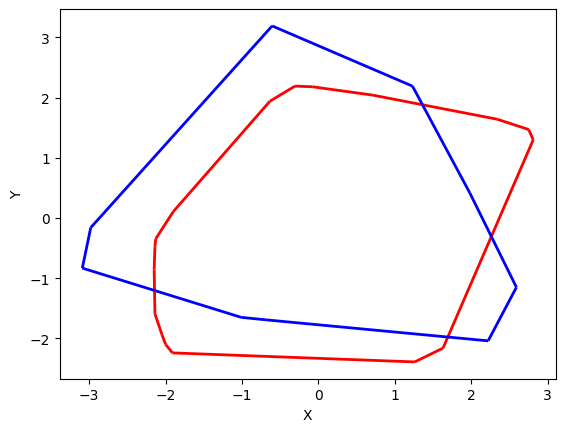

Não é linearmente separável


In [ ]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/unprocessed/banana.csv"
test_data2(url, "Class", 1, -1, "At1", "At2")

##Teste 6

###Dataset phonema

Teste com o dataset phonema do repositório [standard_classification](https://github.com/Mereep/keel_csv/tree/master/standard_classification/unprocessed).

Esse dataset contém 2 classes.

Foram usados dois dos atributos, At1 e At2, e duas das classes, Ao e Sh, com 70% dos dados para treino e 30% para a execução do teste.

A envoltória vermelha é referente aos dados de treino da classe Ao e a azul refere-se a classe Sh na imagem abaixo. Como nota-se visualmente, as classes não são separáveis.

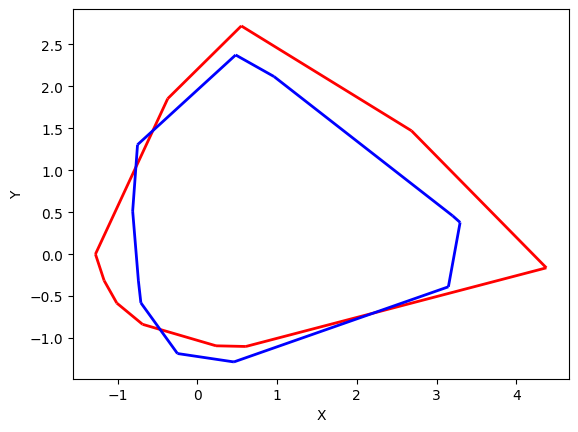

Não é linearmente separável


In [ ]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/unprocessed/phoneme.csv"
test_data2(url, "Class", 0, 1, "Ao", "Sh")

##Teste 7

## Appendicitis dataset

Teste com o dataset appendicitis do repositório [standard_classification](https://github.com/Mereep/keel_csv/blob/master/standard_classification/unprocessed).

Esse dataset contém 2 classes.

Foram usados dois dos atributos, At1 e At2, e duas das classes, 1 e 0, com 70% dos dados para treino e 30% para a execução do teste.

A envoltória vermelha é referente aos dados de treino da classe 1 e a azul refere-se a classe 0 na imagem abaixo. Como nota-se visualmente, as classes não são separáveis.

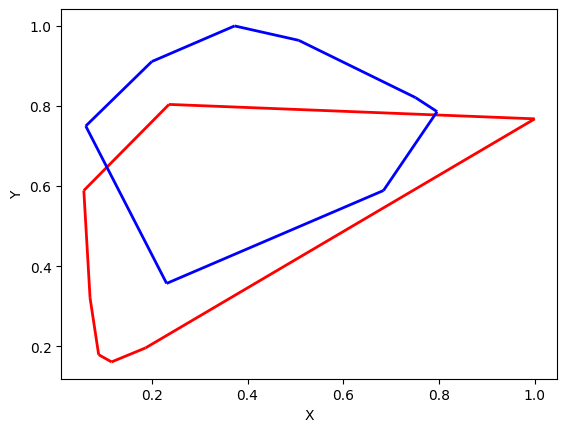

Não é linearmente separável


In [ ]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/unprocessed/appendicitis.csv"
test_data2(url, "Class", 1, 0, "At1", "At2")

##Teste 8

###Sonar dataset

Teste com o dataset sonar do repositório [standard_classification](https://github.com/Mereep/keel_csv/blob/master/standard_classification/unprocessed).

Esse dataset contém 2 classes.

Foram usados dois dos atributos, Band1 e Band2, e duas das classes, R e M, com 70% dos dados para treino e 30% para a execução do teste.

A envoltória vermelha é referente aos dados de treino da classe R e a azul refere-se a classe M na imagem abaixo. Como nota-se visualmente, as classes não são separáveis.


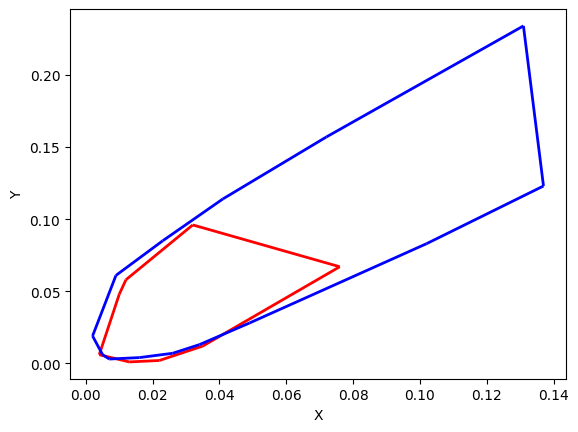

Não é linearmente separável


In [ ]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/unprocessed/sonar.csv"
test_data2(url, "Type", 'R', 'M', "Band1", "Band2")

##Teste 9

###Hepatitis dataset

Teste com o dataset hepatitis do repositório [standard_classification](https://github.com/Mereep/keel_csv/blob/master/standard_classification/unprocessed).

Esse dataset contém 2 classes.

Foram usados dois dos atributos, Age e Spiders, e duas das classes, 1 e 2, com 70% dos dados para treino e 30% para a execução do teste.

A envoltória vermelha é referente aos dados de treino da classe 1 e a azul refere-se a classe 2 na imagem abaixo. Como nota-se visualmente, as classes não são separáveis.


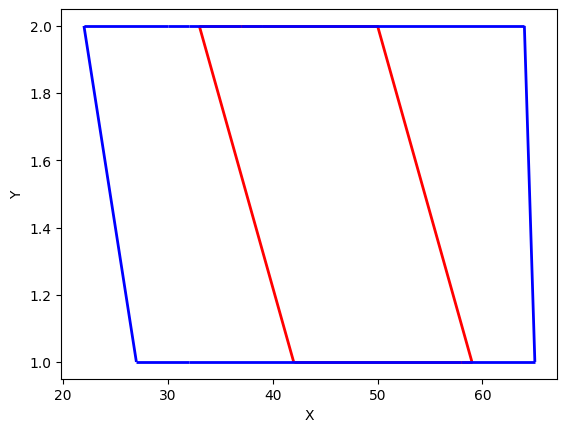

Não é linearmente separável


In [ ]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/unprocessed/hepatitis.csv"
test_data2(url, "Class", 1, 2, "Age", "Spiders")

##Teste 10

###Bupa dataset

Teste com o dataset Bupa do repositório [standard_classification](https://github.com/Mereep/keel_csv/blob/master/standard_classification/unprocessed).

Esse dataset contém 2 classes.

Foram usados dois dos atributos, Mcv e Alkphos, e duas das classes, 1 e 2, com 70% dos dados para treino e 30% para a execução do teste.

A envoltória vermelha é referente aos dados de treino da classe 1 e a azul refere-se a classe 2 na imagem abaixo. Como nota-se visualmente, as classes não são separáveis.


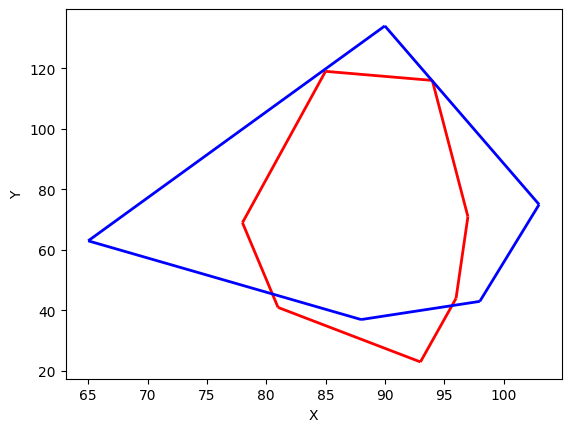

Não é linearmente separável


In [ ]:
url = "https://media.githubusercontent.com/media/Mereep/keel_csv/master/standard_classification/unprocessed/bupa.csv"
test_data2(url, "Selector", 1, 2, "Mcv", "Alkphos")

#**Conclusao**
Com esse trabalho foi possível colocar em prática os algoritmos geométricos vistos em sala de modo que tivemos que aprender a lidar com várias estruturas distintas para conseguir adaptar os conceitos vistos com o problema proposto. Também foi possível notar a complexidade de lidar com dados reais onde tivemos vários problemas quando tentamos lidar com entradas de dados muito grandes. Além disso é importante notar que esse modelo não é ótimo, além das simplificações feitas para o 2D, a escolha da menor distância entre dois poligonos como o segmento entre os vértices de menor distância entre si não nos dá uma divisão correta do plano, visto que isso nem sempre é verdade, gerando resultados estranhos como os do Teste 1 onde as duas envoltórias ficaram praticamente do mesmo lado do plano. Dito isso, o trabalho foi bem eficáz em fixar os conceitos vistos em sala de aula.